**Table of contents**<a id='toc0_'></a>    
- [Load Ticker Pair list](#toc1_1_1_)    
    - [Config Data From Files](#toc1_1_2_)    
    - [Load and Merge Data for Pair](#toc1_1_3_)    
    - [calculate spread](#toc1_1_4_)    
    - [Create Target](#toc1_1_5_)    
  - [Dataset Setup](#toc1_2_)    
    - [Train regression again with low importance columns removed](#toc1_2_1_)    
- [General Setup](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [30]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
data_dir = '../data/'
price_history_dir = data_dir + f'{data_dir}price_history/'
sentiment_dir = data_dir + f'{data_dir}sentiments/'
ti_dir = data_dir + f'{data_dir}technical_indicators/'

### <a id='toc1_1_1_'></a>[Load Ticker Pair list](#toc0_)

In [32]:
import glob

tickers_list = [file.split('/')[-1].strip('.csv') for file in glob.glob(price_history_dir + '*.csv')]
tickers_list
pairs_df = pd.read_csv(data_dir + 'ranked_pairs_snp.csv')
pairs = pairs_df[['ticker_0', 'ticker_1']].values

unique_pairs= pairs_df[['ticker_0', 'ticker_1']].drop_duplicates('ticker_0', keep='first').drop_duplicates('ticker_1', keep='first')

### <a id='toc1_1_2_'></a>[Config Data From Files](#toc0_)

In [33]:
ticker = 'AAPL'

price_history = pd.read_csv(price_history_dir + f'{ticker}.csv')
sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv')
ti = pd.read_csv(ti_dir + f'{ticker}.csv')

data = {}


class TickerData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history = pd.read_csv(price_history_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.ti = pd.read_csv(ti_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
    def __repr__(self):
        return repr(self.history['Adj Close'])

class DATA:
    pass

for ticker in tickers_list:
    setattr(DATA, ticker, TickerData(ticker))

    data[ticker] = TickerData(ticker)
    

In [34]:
display(DATA.AAPL.history.head(2))
display(DATA.AAPL.sentiment.head(2))
display(DATA.AAPL.ti.head(2))


,High,Low,Open,Volume,Adj Close
Date,,,,,
2021-01-04,133.6116,126.76,133.52,143301887.0,129.41
2021-01-05,131.7400,128.43,128.89,97664898.0,131.01


,news_pos_sentiment_count,news_sentiment_daily_avg,twitter_pos_sentiment_count
Date,,,
2021-01-01,11.0,0.0109,15
2021-01-04,3.0,-0.0008,6


,High,Low,Open,Volume,Adj Close,P,R1,R2,R3,S1,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,133.6116,126.76,133.52,143301887.0,129.41,129.927200,132.544511,134.161489,136.778800,127.309889,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,129.410000,0.00000,0.0000,0.00000
2021-01-05,131.7400,128.43,128.89,97664898.0,131.01,130.393333,131.657753,132.438913,133.703333,129.128913,...,0.098538,0.019708,0.078831,-2.60186,-0.520372,-2.081488,130.210469,1.23638,1.2288,1.23638


In [35]:
def add_moving_averages(df, moving_averages, columns):
    df = df.copy()
    for ma in moving_averages:
        for col in columns:
            new_col = f'{col}_ma{ma}'
            df[new_col] = df[col].rolling(window=ma).mean()
    # ffill na
    df.fillna(method='ffill', inplace=True)
    return df


### <a id='toc1_1_3_'></a>[Load and Merge Data for Pair](#toc0_)
change PAIR_IDX to the pair you want to analyze

In [36]:
PAIR_IDX = 0

pair = pairs[PAIR_IDX]

print(pair)

ADD_SENTIMENT_MA = False

# Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
pair_sentiment_df = pd.merge(
    data[pair[0]].sentiment,
    data[pair[1]].sentiment,
    left_index=True,
    right_index=True,
    suffixes=("_S1", "_S2"),
)
if ADD_SENTIMENT_MA:
    pair_sentiment_df = add_moving_averages(
        pair_sentiment_df, [5, 10, 20], columns=pair_sentiment_df.columns
    )

# Join Technical Indicators
pair_ti_df = pd.merge(
    data[pair[0]].ti,
    data[pair[1]].ti,
    left_index=True,
    right_index=True,
    suffixes=("_S1", "_S2"),
)

pair_df = pd.merge(
    pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left"
)

print(pair_df.shape, pair_df.shape[0] * pair_df.shape[1])
pair_df

['GS' 'BLK']
(815, 250) 203750


,High_S1,Low_S1,Open_S1,Volume_S1,Adj Close_S1,P_S1,R1_S1,R2_S1,R3_S1,S1_S1,...,momentum_kama_S2,others_dr_S2,others_dlr_S2,others_cr_S2,news_pos_sentiment_count_S1,news_sentiment_daily_avg_S1,twitter_pos_sentiment_count_S1,news_sentiment_daily_avg_S2,twitter_pos_sentiment_count_S2,news_pos_sentiment_count_S2
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,267.5800,260.16,267.00,3572043.0,265.00,264.246667,267.081107,268.832227,271.666667,261.412227,...,710.820000,0.000000,0.000000,0.000000,1.0,0.0288,2.0,0.0000,3.0,0.0
2021-01-05,273.5000,262.57,263.88,4207081.0,270.93,269.000000,273.175260,275.754740,279.930000,264.824740,...,711.781761,0.528967,0.527572,0.528967,1.0,-0.0050,4.0,-0.0033,5.0,1.0
2021-01-06,288.3800,273.10,276.29,6383530.0,285.55,282.343333,288.180293,291.786373,297.623333,276.506373,...,715.889411,2.852025,2.812112,3.396078,3.0,-0.0136,11.0,0.0015,15.0,1.0
2021-01-07,295.8894,286.68,287.77,4009730.0,291.65,291.406467,294.924457,297.097876,300.615867,287.888476,...,721.959285,2.103516,2.081697,5.571031,2.0,0.0016,13.0,-0.1397,17.0,0.0
2021-01-08,292.2800,285.06,292.00,2800784.0,290.08,289.140000,291.898040,293.601960,296.360000,286.381960,...,725.476664,0.803550,0.800339,6.419347,2.0,0.0033,11.0,-0.2462,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,410.4600,403.86,406.87,1683977.0,404.94,406.420000,408.941200,410.498800,413.020000,403.898800,...,813.015424,-1.045064,-1.050563,14.826538,2.0,0.0087,15.0,-0.0060,11.0,0.0
2024-03-26,409.3300,404.52,406.09,1406974.0,406.18,406.676667,408.514087,409.649247,411.486667,404.839247,...,813.119753,0.488845,0.487654,15.387862,0.0,-0.0096,18.0,-0.0008,25.0,0.0
2024-03-27,415.4900,408.37,409.62,2353629.0,415.25,413.036667,415.756507,417.436827,420.156667,410.316827,...,813.402999,1.819069,1.802721,17.486846,0.0,-0.0035,17.0,-0.0001,22.0,2.0



### <a id='toc1_1_4_'></a>[calculate spread](#toc0_)


<Axes: title={'center': 'Spread'}, xlabel='Date'>

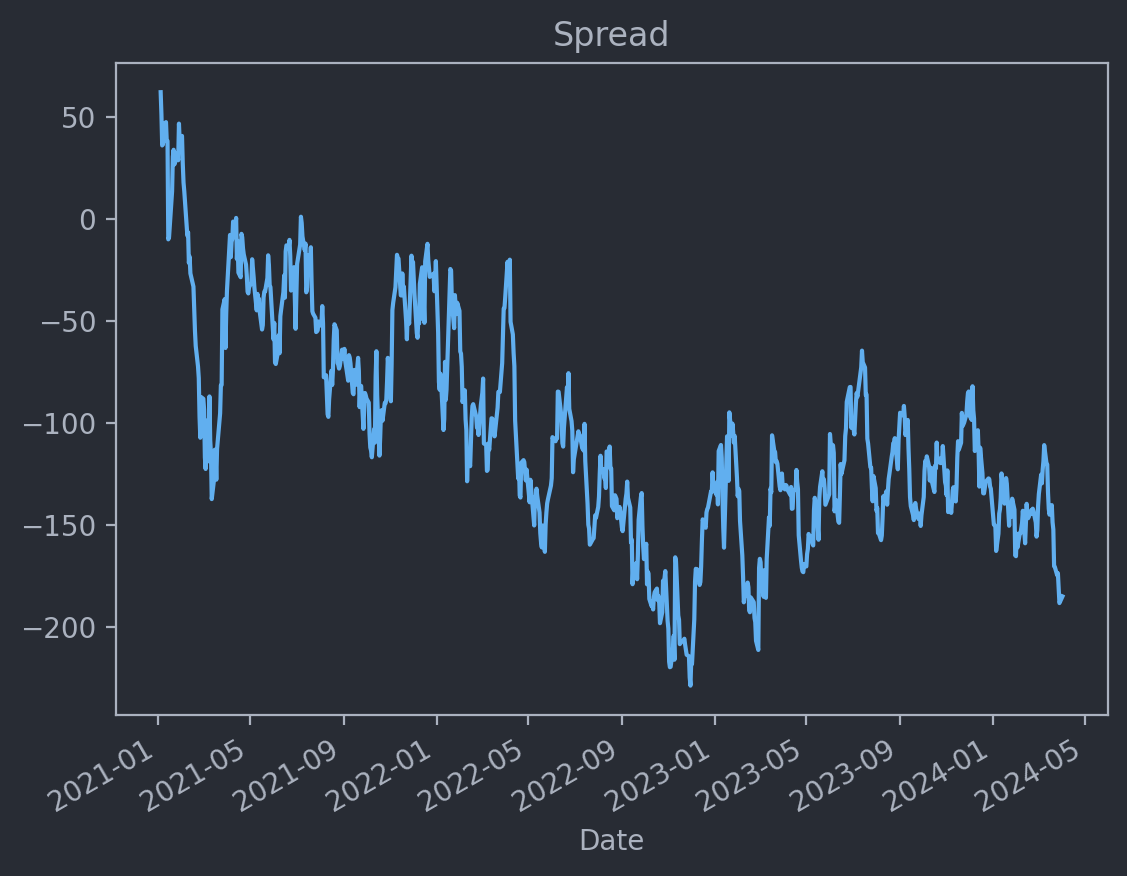

In [37]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread


def norm_plot(df):
    df=df.copy()
    df = (df - df.mean()) / df.std()
    return df



SPREAD_WINDOW = None

# NOTE: Should only be implemented on Train set
spread = get_spread(pair_df['Adj Close_S1'], pair_df['Adj Close_S2'], window=SPREAD_WINDOW)
pair_df['spread'] = spread

pair_df['spread'].plot(title='Spread')


### <a id='toc1_1_5_'></a>[Create Target](#toc0_)

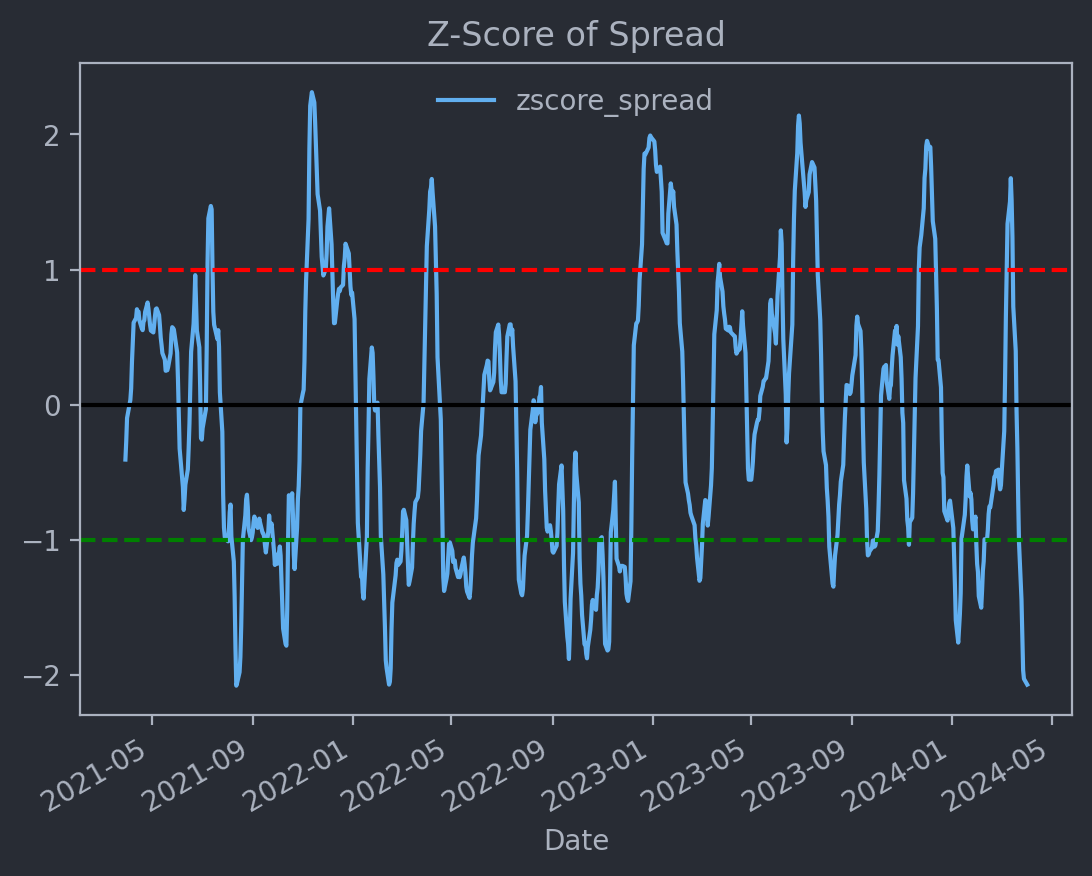

,High_S1,Low_S1,Open_S1,Volume_S1,Adj Close_S1,P_S1,R1_S1,R2_S1,R3_S1,S1_S1,...,others_dlr_S2,others_cr_S2,news_pos_sentiment_count_S1,news_sentiment_daily_avg_S1,twitter_pos_sentiment_count_S1,news_sentiment_daily_avg_S2,twitter_pos_sentiment_count_S2,news_pos_sentiment_count_S2,spread,zscore_spread
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,267.5800,260.16,267.00,3572043.0,265.00,264.246667,267.081107,268.832227,271.666667,261.412227,...,0.000000,0.000000,1.0,0.0288,2.0,0.0000,3.0,0.0,62.319539,NaN
2021-01-05,273.5000,262.57,263.88,4207081.0,270.93,269.000000,273.175260,275.754740,279.930000,264.824740,...,0.527572,0.528967,1.0,-0.0050,4.0,-0.0033,5.0,1.0,51.567812,NaN
2021-01-06,288.3800,273.10,276.29,6383530.0,285.55,282.343333,288.180293,291.786373,297.623333,276.506373,...,2.812112,3.396078,3.0,-0.0136,11.0,0.0015,15.0,1.0,36.170164,NaN
2021-01-07,295.8894,286.68,287.77,4009730.0,291.65,291.406467,294.924457,297.097876,300.615867,287.888476,...,2.081697,5.571031,2.0,0.0016,13.0,-0.1397,17.0,0.0,36.702417,NaN
2021-01-08,292.2800,285.06,292.00,2800784.0,290.08,289.140000,291.898040,293.601960,296.360000,286.381960,...,0.800339,6.419347,2.0,0.0033,11.0,-0.2462,9.0,1.0,46.574477,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,410.4600,403.86,406.87,1683977.0,404.94,406.420000,408.941200,410.498800,413.020000,403.898800,...,-1.050563,14.826538,2.0,0.0087,15.0,-0.0060,11.0,0.0,-174.747648,-1.442855
2024-03-26,409.3300,404.52,406.09,1406974.0,406.18,406.676667,408.514087,409.649247,411.486667,404.839247,...,0.487654,15.387862,0.0,-0.0096,18.0,-0.0008,25.0,0.0,-173.792140,-1.707300
2024-03-27,415.4900,408.37,409.62,2353629.0,415.25,413.036667,415.756507,417.436827,420.156667,410.316827,...,1.802721,17.486846,0.0,-0.0035,17.0,-0.0001,22.0,2.0,-181.067986,-1.967804


In [38]:

# We want to predict the z-score of spread, to forecast deviations from the mean

# The Z-score of the spread will be used to determine when to buy and sell
# We use a low/high moving average to calculate the z-score. 
# This is so that the z-score is not affected by the spread increasing over time
# Can play around with the window sizes to see what works best

# Moving Z score Calculation (Trading Signal)
ma_high = pair_df.spread.rolling(window=60).mean()
ma_low = pair_df.spread.rolling(window=5).mean()
std_high = pair_df.spread.rolling(window=60).std()

moving_zscore = (ma_low - ma_high) / std_high
pair_df['zscore_spread'] = moving_zscore


pair_df['zscore_spread'].plot(title='Z-Score of Spread')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend()
plt.show()
pair_df

In [39]:
plt.style.use('custom_onedark')

In [40]:
from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error


def create_dataset(data, look_back, target_col="spread_close", split_sizes=[0.7, 0.2, 0.1], drop_cols: list = []):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)

    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size



    print("------Dataset Information------")
    print(tabulate([
            ["Train", train_size, data.index[train_size].date()], 
            ["Val", val_size, data.index[-val_size].date()],
            ["Test", test_size, data.index[-test_size].date()]],
        ["Set", "Size", "Date Cutoff"]))

    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[-test_size:]
    return train_data, val_data, test_data


def prepare_dataset(train_data, val_data, test_data):
    X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
    X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
    X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test



## <a id='toc1_2_'></a>[Dataset Setup](#toc0_)

In [41]:
# Parameters
LOOK_BACK = 3
DROP_COLS = [
   
]

train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=DROP_COLS
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])

------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     525  2023-05-02
Val       150  2023-08-21
Test       76  2023-12-05


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def calculate_metrics(y_true, y_pred):
    metric_frame = {
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }
    print(f"\nR2: {metric_frame['r2']:.2f}, MAE: {metric_frame['mae']:.2f}, MAPE: {metric_frame['mape']*100:.2f}%")



R2: -1.28, MAE: 1.21, MAPE: 348.38%


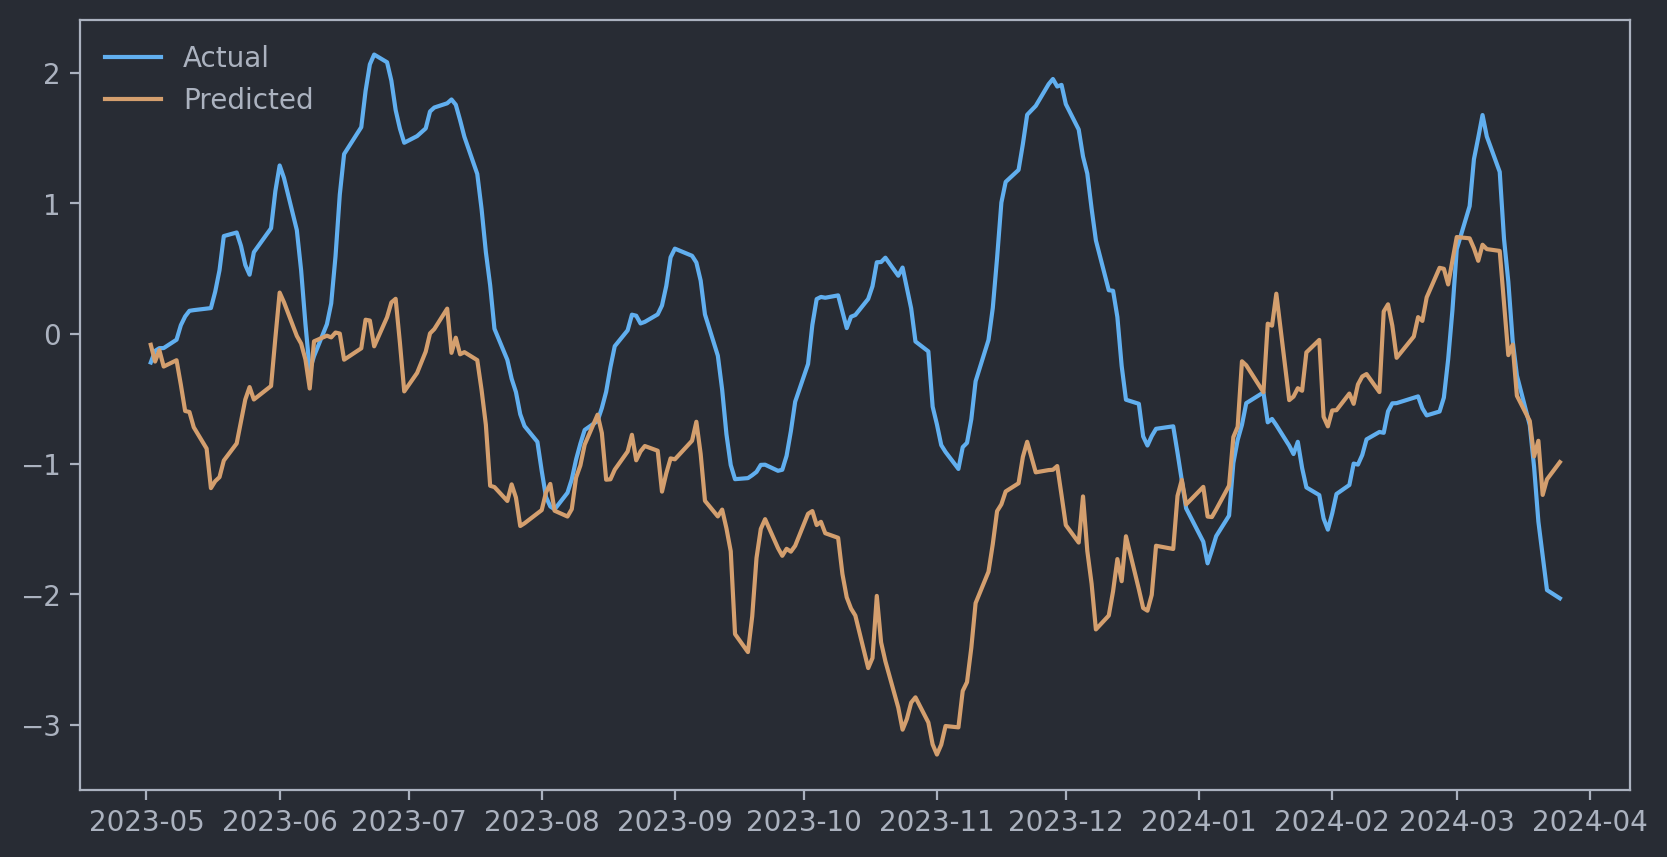

In [43]:
# ---- Model Training ----
model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)

model_results = {}
model_results['Vanilla Regression'] = calculate_metrics(y_test, y_pred)


fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

# get feature importance
feature_importance = model_reg.coef_
features = X_train.columns
feature_importance_df = pd.DataFrame({"feature": features, "importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

In [49]:
print('Original Feature Dim:', feature_importance_df.shape[0])

# Can Change Thresholds, By no means are these the best thresholds
# Should use another method for feature selection, this was just for demonstration
low_importance_df = feature_importance_df[(feature_importance_df['importance'] < 1) & (feature_importance_df['importance'] > -1)]
print('Low Importance Feature Dim:', low_importance_df.shape[0])

low_importance_cols = low_importance_df.feature.to_list()
high_importance_df = feature_importance_df[(feature_importance_df['importance'] >= 1) | (feature_importance_df['importance'] <= -1)]

Original Feature Dim: 252
Low Importance Feature Dim: 200


### <a id='toc1_2_1_'></a>[Train regression again with low importance columns removed](#toc0_)

------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     525  2023-05-02
Val       150  2023-08-21
Test       76  2023-12-05

R2: 0.72, MAE: 0.39, MAPE: 94.40%


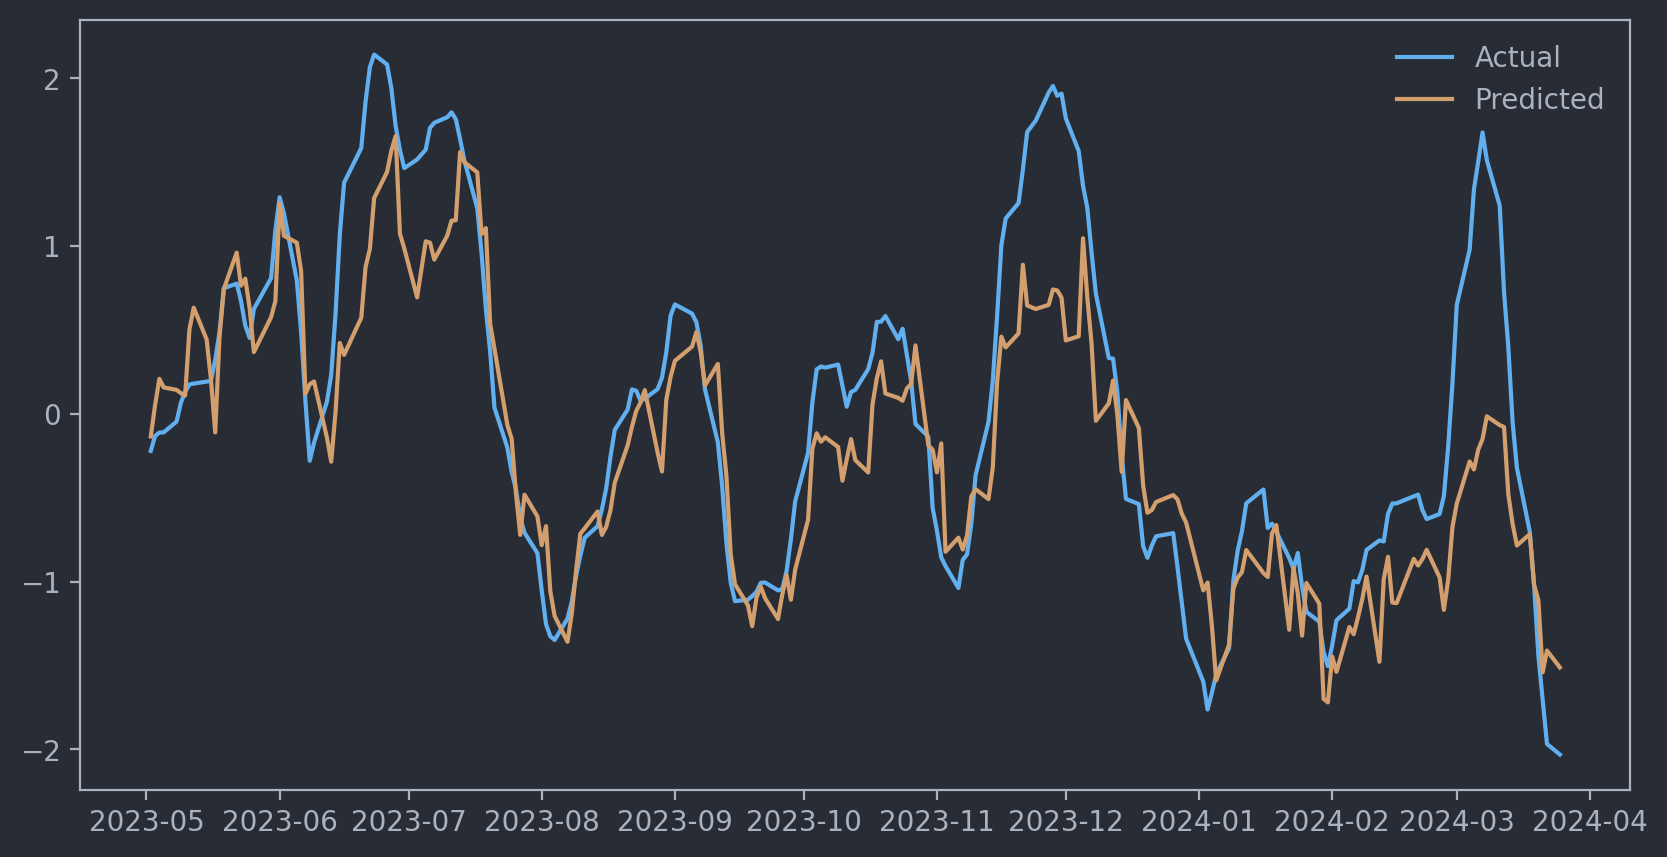

In [45]:

train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=low_importance_cols
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])



model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)


model_results['Regression with Feature Selection'] = calculate_metrics(y_test, y_pred)

fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

plt.show()

# <a id='toc2_'></a>[General Setup](#toc0_)

In [3]:
def add_moving_averages(df, moving_averages, columns):
    df = df.copy()
    for ma in moving_averages:
        for col in columns:
            new_col = f'{col}_ma{ma}'
            df[new_col] = df[col].rolling(window=ma).mean()
    # ffill na
    df.fillna(method='ffill', inplace=True)
    return df

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread


def norm_plot(df):
    df=df.copy()
    df = (df - df.mean()) / df.std()
    return df

from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error


def create_dataset(data, look_back, target_col="spread_close", split_sizes=[0.7, 0.2, 0.1], drop_cols: list = []):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)

    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size



    print("------Dataset Information------")
    print(tabulate([
            ["Train", train_size, data.index[train_size].date()], 
            ["Val", val_size, data.index[-val_size].date()],
            ["Test", test_size, data.index[-test_size].date()]],
        ["Set", "Size", "Date Cutoff"]))

    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[-test_size:]
    return train_data, val_data, test_data


def prepare_dataset(train_data, val_data, test_data):
    X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
    X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
    X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test



In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS



data_dir = '../data/'
price_history_dir = data_dir + f'{data_dir}price_history/'
sentiment_dir = data_dir + f'{data_dir}sentiments/'
ti_dir = data_dir + f'{data_dir}technical_indicators/'

import glob

# Load Ticker Pairs
tickers_list = [file.split('/')[-1].strip('.csv') for file in glob.glob(price_history_dir + '*.csv')]
pairs_df = pd.read_csv(data_dir + 'ranked_pairs_snp.csv')
pairs = pairs_df[['ticker_0', 'ticker_1']].values
unique_pairs= pairs_df[['ticker_0', 'ticker_1']].drop_duplicates('ticker_0', keep='first').drop_duplicates('ticker_1', keep='first')


# Load Ticker History, Sentiment and Technical Indicators
data = {}
class TickerData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history = pd.read_csv(price_history_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.ti = pd.read_csv(ti_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
    def __repr__(self):
        return repr(self.history['Adj Close'])

class DATA:
    pass

for ticker in tickers_list:
    setattr(DATA, ticker, TickerData(ticker))

    data[ticker] = TickerData(ticker)


# Pair Selection
PAIR_IDX = 0
ADD_SENTIMENT_MA = False


pair = pairs[PAIR_IDX]
print(pair)

# Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
pair_sentiment_df = pd.merge( data[pair[0]].sentiment, data[pair[1]].sentiment, left_index=True, right_index=True, suffixes=("_S1", "_S2"),)
if ADD_SENTIMENT_MA:
    pair_sentiment_df = add_moving_averages(pair_sentiment_df, [5, 10, 20], columns=pair_sentiment_df.columns)

# Join Technical Indicators
pair_ti_df = pd.merge( data[pair[0]].ti, data[pair[1]].ti, left_index=True, right_index=True, suffixes=("_S1", "_S2"))
pair_df = pd.merge(pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left")



# ---- Dataset Setup ----
# We want to predict the z-score of spread, to forecast deviations from the mean

# The Z-score of the spread will be used to determine when to buy and sell
# We use a low/high moving average to calculate the z-score.
# This is so that the z-score is not affected by the spread increasing over time
# Can play around with the window sizes to see what works best

SPREAD_WINDOW = None
MA_HIGH = 60
MA_LOW = 5


# --- Feature Selection Setup ---

# Parameters
LOOK_BACK = 3
DROP_COLS = [

]

train_data, val_data, test_data = create_dataset(pair_df,
                                                 look_back=LOOK_BACK,
                                                 target_col="zscore_spread",
                                                 drop_cols=DROP_COLS)

# Calculate spread using only training data
spread_full, beta = get_spread(
    train_data['Adj Close_S1'],
    train_data['Adj Close_S2'],
    data['Adj Close_S1'],
    data['Adj Close_S2']
)

data['spread'] = spread_full

# Calculate Moving Z score Calculation (Trading Signal)
ma_high = pair_df.spread.rolling(window=MA_HIGH).mean()
ma_low = pair_df.spread.rolling(window=MA_LOW).mean()
std_high = pair_df.spread.rolling(window=MA_HIGH).std()

moving_zscore = (ma_low - ma_high) / std_high
pair_df['zscore_spread'] = moving_zscore


X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])

pair_df

['GS' 'BLK']
------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     525  2023-05-02
Val       150  2023-08-21
Test       76  2023-12-05


,High_S1,Low_S1,Open_S1,Volume_S1,Adj Close_S1,P_S1,R1_S1,R2_S1,R3_S1,S1_S1,...,others_dlr_S2,others_cr_S2,news_pos_sentiment_count_S1,news_sentiment_daily_avg_S1,twitter_pos_sentiment_count_S1,news_sentiment_daily_avg_S2,twitter_pos_sentiment_count_S2,news_pos_sentiment_count_S2,spread,zscore_spread
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,267.5800,260.16,267.00,3572043.0,265.00,264.246667,267.081107,268.832227,271.666667,261.412227,...,0.000000,0.000000,1.0,0.0288,2.0,0.0000,3.0,0.0,62.319539,NaN
2021-01-05,273.5000,262.57,263.88,4207081.0,270.93,269.000000,273.175260,275.754740,279.930000,264.824740,...,0.527572,0.528967,1.0,-0.0050,4.0,-0.0033,5.0,1.0,51.567812,NaN
2021-01-06,288.3800,273.10,276.29,6383530.0,285.55,282.343333,288.180293,291.786373,297.623333,276.506373,...,2.812112,3.396078,3.0,-0.0136,11.0,0.0015,15.0,1.0,36.170164,NaN
2021-01-07,295.8894,286.68,287.77,4009730.0,291.65,291.406467,294.924457,297.097876,300.615867,287.888476,...,2.081697,5.571031,2.0,0.0016,13.0,-0.1397,17.0,0.0,36.702417,NaN
2021-01-08,292.2800,285.06,292.00,2800784.0,290.08,289.140000,291.898040,293.601960,296.360000,286.381960,...,0.800339,6.419347,2.0,0.0033,11.0,-0.2462,9.0,1.0,46.574477,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,410.4600,403.86,406.87,1683977.0,404.94,406.420000,408.941200,410.498800,413.020000,403.898800,...,-1.050563,14.826538,2.0,0.0087,15.0,-0.0060,11.0,0.0,-174.747648,-1.442855
2024-03-26,409.3300,404.52,406.09,1406974.0,406.18,406.676667,408.514087,409.649247,411.486667,404.839247,...,0.487654,15.387862,0.0,-0.0096,18.0,-0.0008,25.0,0.0,-173.792140,-1.707300
2024-03-27,415.4900,408.37,409.62,2353629.0,415.25,413.036667,415.756507,417.436827,420.156667,410.316827,...,1.802721,17.486846,0.0,-0.0035,17.0,-0.0001,22.0,2.0,-181.067986,-1.967804
